# Shapley indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Ishigami Framework

In [106]:
from shapley.tests import Ishigami

model = Ishigami()
dim = model.dim
model.copula = ot.NormalCopula(dim)
theta = 0.6
model.copula_parameters = [-0.3, theta, 0.5]
model.copula_parameters = [0.]*dim

### Monte-Carlo estimation using true model

In [107]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_perms = None
n_var = 10000
n_outer = 200
n_inner = 100
budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 250000
Wall time: 2.83 s


In [108]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 300
shapley_results = shapley.compute_indices(n_boot=n_boot)

Wall time: 855 ms


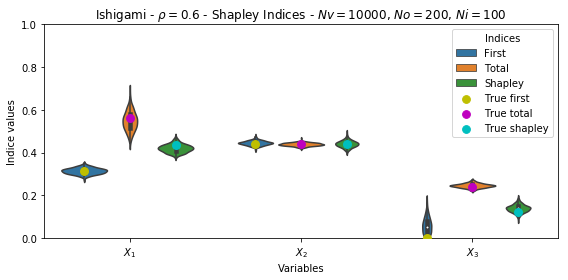

In [109]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_results, indice='all', ax=ax)
ax.set_title("Ishigami - $\\rho = {0}$ - Shapley Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [110]:
X = np.asarray(model.get_input_sample(10000, 'monte-carlo'))
y = model(X)

In [111]:
from skgarden import RandomForestQuantileRegressor
from shapley.forest import compute_perm_indices, compute_shap_indices
n_tree = 300
rfq = RandomForestQuantileRegressor(n_estimators=n_tree, n_jobs=7)
rfq.fit(X, y)

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=7,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)

In [112]:
indices = compute_shap_indices(rfq, X, y)

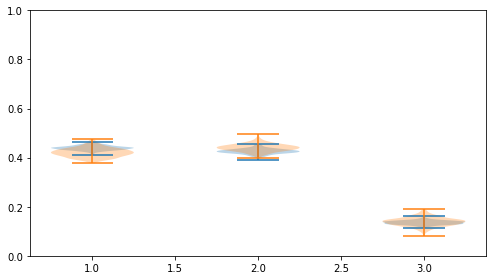

In [113]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.violinplot(indices.T)
ax.violinplot(shapley_results.full_shapley_indices.T)
#ax.violinplot(sobol_results['full'].full_total_indices.T)
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [6]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 100
sampling = 'lhs'
library = 'gpflow'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling, sampling_type='uniform')
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [7]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_gp)

('Q2-score by cross-validation:', 0.82866409574448652)


In [ ]:
%%time
n_realization = 200
shapley.build_sample(model=model_gp, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

CPU times: user 1min 23s, sys: 4.36 s, total: 1min 27s
Wall time: 1min 3s


In [ ]:
%%time
# Indice estimation
shapley_gp_results = shapley.compute_indices(n_boot=n_boot)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_gp_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_gp_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_gp_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_gp_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [ ]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling)
model_rf.build(n_realization, method='random-forest')

In [ ]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000, sampling='monte-carlo')
print('Q2-score by cross-validation:', q2_score_cv_rf)

In [ ]:
%%time
shapley.build_sample(model=model_rf, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner, n_realization=n_realization)

In [ ]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

shapley_rf_results = shapley.compute_indices(n_boot=n_boot)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_rf_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(shapley_rf_results, indice='all', ax=ax)
ax.set_title("Additive Gaussian $\\rho = {0}$ - Kriging Indices - $Nv={1}$, $No={2}$, $Ni={3}$".format(theta, n_var, n_outer, n_inner))
ax.set_ylim(ylim)
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True)

ax = axes[0]
plot_sensitivity_results(shapley_rf_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_xlabel('')
ax.set_ylabel('First Sobol indices')
ax.legend(loc=2)

ax = axes[1]
plot_sensitivity_results(shapley_rf_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_xlabel('')
ax.set_ylabel('Total Sobol indices')

ax = axes[2]
plot_sensitivity_results(shapley_rf_results, indice='shapley', ax=ax)
ax.set_ylim(ylim)
ax.legend(loc=2)
ax.set_ylabel('Shapley effects')

fig.tight_layout()